In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import umap
from torch.nn.functional import mse_loss

from autoencoder import Autoencoder
from solver import *

In [2]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=6)

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=6)

In [3]:
def load_model(model_path, model_type, epoch):
    n_input = 28*28
    n_layers = 3
    sae_n_hidden_ls = [512, 128, 32]

    size_ls = [4, 4, 4, 4, 4, 10,
            10, 10, 10, 10, 16, 16,
            16, 16, 16, 16, 16, 24,
            24, 24, 24, 24, 24, 24, 
            32, 32, 32, 32, 32, 32,
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32]
    
    dae_n_hidden_ls = [512, 128, size_ls[epoch]]
    
    if model_type == 'SAE':
        model = Autoencoder(n_input, sae_n_hidden_ls, n_layers)
    else:
        model = Autoencoder(n_input, dae_n_hidden_ls, n_layers)
    weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")
    model.load_state_dict(weights)
    return model

In [4]:
modelpath = f'/home/david/sparsify_models/good_models/01'

sae = load_model(modelpath, 'SAE', epoch=49)
dae = load_model(modelpath, 'DAE', epoch=49)

/tmp/ipykernel_63930/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")


In [13]:
train_images = []
train_labels = []

for batch_idx, (data, target) in enumerate(train_loader):
    data = Variable(data)
    train_images.append(data)
    train_labels.append(target)

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data)
    test_images.append(data)
    test_labels.append(target)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

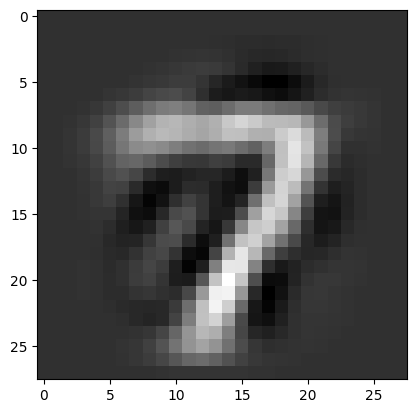

In [6]:
with torch.no_grad():
    # take one test image. encode it. add noise to the first element of the encoding. decode it.
    sample_image = test_images[0]
    sample_image = torch.tensor(sample_image).to('cuda')
    input = sample_image.view(1, -1).to('cpu')
    encoded = dae.encode(input)
    encoded[0][0] = 0
    decoded = dae.decode(encoded)
    decoded = decoded.view(28, 28).cpu().numpy()
    plt.imshow(decoded, cmap='gray')
    plt.show()
    

In [14]:
dae_test_encodings = []

with torch.no_grad():
    for image in test_images:
        image = torch.tensor(image).view(-1)
        input = image.view(1, -1)
        encoded, decoded = dae(input)
        dae_test_encodings.append(encoded)

dae_test_encodings = np.concatenate(dae_test_encodings)

In [9]:
dae_test_encodings.shape

(10000, 32)

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(torch.tensor(test_images).view(-1))

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. ... 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.